# UNet 실습

![UNet](https://drive.google.com/uc?export=view&id=1scmhSKYgyHC70_1caI_QsYUMFgMTAg9s)

In [ ]:
import os
import sys
print(os.getcwd())
!ls

/content
sample_data


In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [ ]:
project_path = '/content/MyDrive/MyDrive/Colab Notebooks/MNC_실습자료/220118_Segmentation/DeepLabv3_Tutorial'
sys.path.insert(0, project_path)

In [ ]:
# For download pascal voc 2007 dataset
from torchvision.datasets import VOCSegmentation
VOCSegmentation(root=os.path.join(project_path, 'data'), year='2007', download=False)

Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: /content/MyDrive/MyDrive/Colab Notebooks/MNC_실습자료/220118_Segmentation/1_DeepLabv3_Tutorial/data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
import os
import albumentations as A
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from torchvision.utils import save_image

class DatasetFromFolderVOC(Dataset):
    def __init__(self, root_dir=os.path.join(project_path,'data/VOCdevkit/VOC2007'), txt_file='train.txt', transforms=None):
        super(DatasetFromFolderVOC, self).__init__()
        with open(os.path.join(root_dir, 'ImageSets/Segmentation', txt_file), 'r') as f:
            self.filenames = f.readlines()
        self.filenames = [file.strip() for file in self.filenames]
        self.img_path = os.path.join(root_dir, "JPEGImages") #root_dir과 JPEGImages를 붙여서 만듦
        self.gt_path = os.path.join(root_dir, "SegmentationClass") #root_dir과 SegmentationClass를 붙여 만듦
        self.transforms = transforms
        self.pallete = Image.open(os.path.join(self.gt_path, f'{self.filenames[0]}.png')).getpalette()

    # getitem 함수는 index에 맞는 data를 반환하는 역할을 합니다.
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, f'{self.filenames[index]}.jpg')) #이미지를 불러오는 부분, index를 통해 이미지 patch에서 이미지를 불러오고 PIL의 Image 모듈로 오픈함 
        gt = Image.open(os.path.join(self.gt_path, f'{self.filenames[index]}.png'))

        aug = self.transforms(image=np.array(img), mask=np.array(gt))
        img = to_tensor(aug['image'])
        gt = aug['mask']
        gt[gt > 20] = 0
        gt = torch.tensor(gt)

        return img, gt

    # len 함수는 Dataset 전체 개수를 반환합니다.
    def __len__(self):
        return len(self.filenames)


In [ ]:
transform = A.Compose([
    A.Resize(512, 512),
    #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

dataset = DatasetFromFolderVOC(transforms=transform)
img, gt = dataset[0]
pallete = dataset.pallete

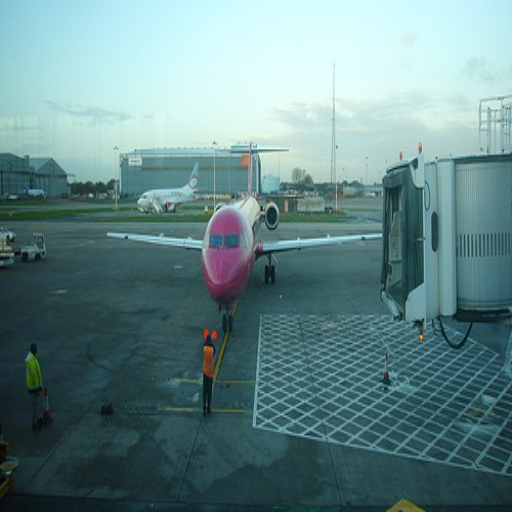

In [ ]:
tf = transforms.ToPILImage()
tf(img)

In [ ]:
gt_img = tf(gt)
gt_img.putpalette(dataset.pallete)

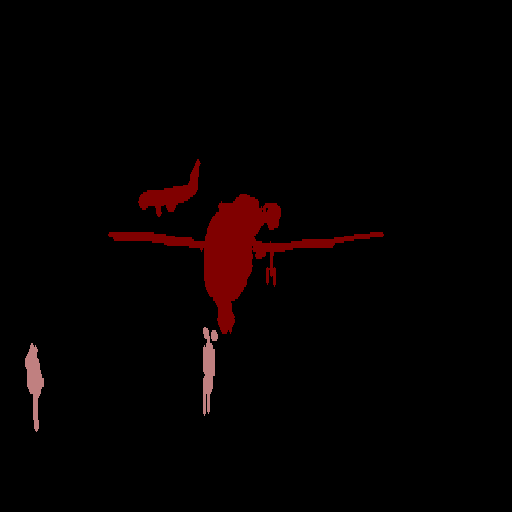

In [ ]:
gt_img

In [ ]:
from torch.utils.data import DataLoader

transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

train_set = DatasetFromFolderVOC(txt_file='train.txt', transforms=transform)
test_set = DatasetFromFolderVOC(txt_file='val.txt', transforms=transform)

# Training Set과 Test Set을 각각 DataLoader에 넣습니다.
trainDataLoader = DataLoader(dataset=train_set, num_workers=2, batch_size=8, shuffle=True)
testDataLoader = DataLoader(dataset=test_set, num_workers=1, batch_size=1, shuffle=False)

##직접 레이어를 구현해봅시다!

![UNet](https://drive.google.com/uc?export=view&id=1scmhSKYgyHC70_1caI_QsYUMFgMTAg9s)

#### 그림을 참고하여 [Conv, BatchNorm, ReLU] 2개로 구성된 있는 레이어를 구현해 봅시다

In [ ]:
class ConvBlock(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    # Class initialization 인자를 확인해 보세요
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels: # mid_channel이 아닌 경우
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.double_conv(x)
        return x

# Debug = ConvBlock(3, 64)
# input = torch.Tensor(2, 3, 64, 64)
# Debug(input).shape


torch.Size([2, 64, 64, 64])

#### 그림을 참고하여 [Downsampling, ConvBlock] 으로 구성된 레이어를 구현해 봅시다

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )


    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

# Debug = Down(3, 64)
# input = torch.Tensor(2, 3, 64, 64)
# Debug(input).shape

torch.Size([2, 64, 32, 32])

#### 그림을 참고하여 [Upsampling, ConvBlock] 으로 구성된 레이어를 구현해 봅시다

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1) # B C H W 
        x = self.conv(x)

        return x

# Debug = Up(6, 64)
# input1 = torch.Tensor(2, 3, 64, 64)
# input2 = torch.Tensor(2, 3, 128, 128)
# Debug(input1, input2).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([2, 64, 128, 128])

#### 그림을 참고하여 최종 레이어를 구현해 봅시다

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

![UNet](https://drive.google.com/uc?export=view&id=1scmhSKYgyHC70_1caI_QsYUMFgMTAg9s)

#### 앞서 구현한 레이어들을 이용하여 모델을 구현해봅시다

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = ConvBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# U = UNet(3, 10)
# input1 = torch.Tensor(2, 3, 256, 256)
# U(input).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([2, 10, 128, 128])

In [ ]:
num_classes = 21  # 20 + background
model = UNet(3, num_classes).cuda()
model = model.train()
criterion = nn.CrossEntropyLoss()

#### 학습 코드를 완성시켜 봅시다

In [ ]:
import torch.optim as optim
from tqdm import tqdm


# setup optimizer
# optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))

total_epoch = 100

# Training
for epoch in range(total_epoch):
    for i, (img, gt) in enumerate(trainDataLoader):
        img = img.cuda()
        gt = gt.long().cuda()

        # forward and calculate the loss
        pred = model(img)
        loss = criterion(pred, gt)

        # Backprop + Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:        
            print(f'[{epoch+1}][{i+1}/{len(trainDataLoader)}] Loss: {loss.item():.3f}')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[1][1/27] Loss: 3.213
[1][11/27] Loss: 3.103
[1][21/27] Loss: 3.096
[2][1/27] Loss: 3.023
[2][11/27] Loss: 3.021
[2][21/27] Loss: 3.075
[3][1/27] Loss: 2.932
[3][11/27] Loss: 2.927
[3][21/27] Loss: 2.874
[4][1/27] Loss: 2.862
[4][11/27] Loss: 2.776
[4][21/27] Loss: 2.966
[5][1/27] Loss: 2.691
[5][11/27] Loss: 2.611
[5][21/27] Loss: 2.648
[6][1/27] Loss: 2.624
[6][11/27] Loss: 2.695
[6][21/27] Loss: 2.582
[7][1/27] Loss: 2.582
[7][11/27] Loss: 2.601
[7][21/27] Loss: 2.541
[8][1/27] Loss: 2.579
[8][11/27] Loss: 2.649
[8][21/27] Loss: 2.475
[9][1/27] Loss: 2.615
[9][11/27] Loss: 2.455
[9][21/27] Loss: 2.485
[10][1/27] Loss: 2.458
[10][11/27] Loss: 2.450
[10][21/27] Loss: 2.382
[11][1/27] Loss: 2.395
[11][11/27] Loss: 2.383
[11][21/27] Loss: 2.389
[12][1/27] Loss: 2.424
[12][11/27] Loss: 2.409
[12][21/27] Loss: 2.380
[13][1/27] Loss: 2.398
[13][11/27] Loss: 2.521
[13][21/27] Loss: 2.377
[14][1/27] Loss: 2.424
[14][11/27] Loss: 2.358
[14][21/27] Loss: 2.317
[15][1/27] Loss: 2.628
[15][11/27

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


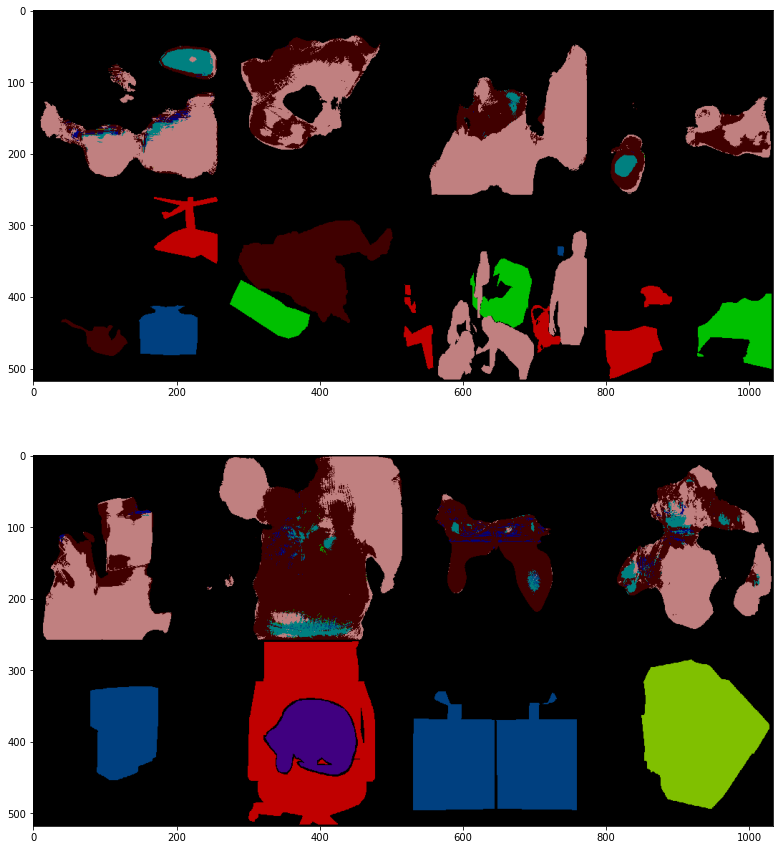

In [ ]:
# Visualization
model.eval()
num_imgs = 4
preds_train, gts_train = None, None
preds_val, gts_val = None, None
for i, (img, gt) in enumerate(trainDataLoader):
    if i * trainDataLoader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)
        output_pred = pred.argmax(1)
        for j in range(min(trainDataLoader.batch_size, 4)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(train_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_train = out_img if i == 0 and j == 0 else torch.cat([preds_train, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(train_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_train = out_img if i == 0 and j == 0 else torch.cat([gts_train, out_img])
            
for i, (img, gt) in enumerate(testDataLoader):
    if i * testDataLoader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)
        output_pred = pred.argmax(1)
        for j in range(min(testDataLoader.batch_size, num_imgs)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(test_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_test = out_img if i == 0 and j == 0 else torch.cat([preds_test, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(test_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_test = out_img if i == 0 and j == 0 else torch.cat([gts_test, out_img])

train_samples = torch.cat([preds_train.cpu(), gts_train])
train_samples = torchvision.utils.make_grid(train_samples, nrow=num_imgs)
train_samples = train_samples.permute(1, 2, 0)

test_samples = torch.cat([preds_test.cpu(), gts_test])
test_samples = torchvision.utils.make_grid(test_samples, nrow=num_imgs)
test_samples = test_samples.permute(1, 2, 0)

plt.rcParams["figure.figsize"] = (30, 15)
plt.subplot(2, 1, 1)
plt.imshow(train_samples)
plt.subplot(2, 1, 2)
plt.imshow(test_samples)